# Daily rainfall time serie extraction, for N pixels of SM2RAIN dataset (Global grid 12.5 km)
Code Improvement: July 2020, L. Duffar https://github.com/loicduffar

Dataset : SM2RAIN https://zenodo.org/record/3635932#.XoWskagzZhG   (<b>Version 1.2 only !</b>)

The original code is amended and completed as described below (LDU):
- Compatibilty with python 3.x
- Process several pixels instead of just one (but also works for 1 single point)
- Allow to modify the start and end years, and to copy and paste the file path
- Calculate monthly totals
- Extract daily and monthly data into a text file
- (for fun) lengthen the time axis of the graphics and improve their aesthetics using the "seaborn" library (and add an interactivity menu to graphs, but does not work)
- (in progress, non-functional), generate a text file containing ALL the global pixels, so that it can be opened in Qgis in a raster layer and thus easily select the pixels included in a watershed

QUICK START:

- Place consecutive SM2RAIN annual files in the same folder (1 file per year from 2007 to 2019)
- Rename the files if necessary when the version number varies depending on the year, which is not dealt with in the code

- 1) Run cell 1 to read and display daily data for the selected coordinates
- 2) Run cell 2 to compute and display monthly precipitations
- 3) Run cell 3 to save daily/monthly precipitations in text files


## 1) Read and display data
- Copy-paste the name of the working folder in the "path" variable of the code (e.g. path = r"c:/...")
- Enter the start and end year in the variables year_start and year_end (e.g. year_start= 2007 and year_end= 2019)
- Enter in the lonlat_.txt file the geographic coordinates of the pixels to extract
- Launch the script and wait until the end of the processing which takes about ten seconds or more depending on the number of pixels

[array([81.67467705,  7.73155179])]


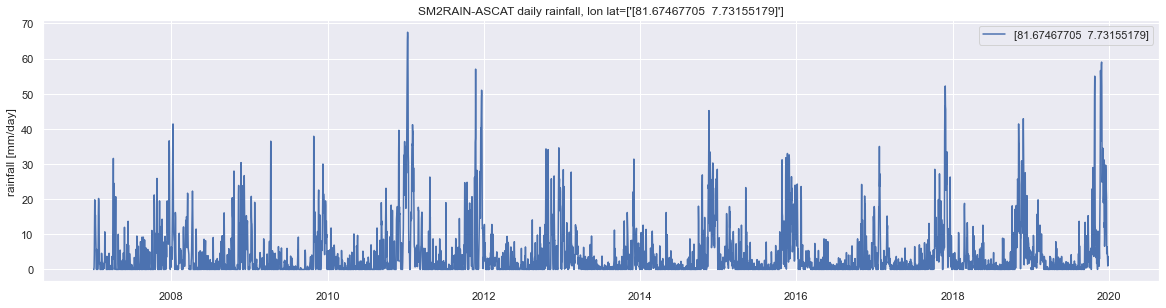

In [35]:
"""
Created on Jul 2020
Original code from https://zenodo.org/record/3635932#.XoWskagzZhG
Improved for N points extraction by @author: Loïc Duffar
"""
%matplotlib notebook
%matplotlib inline
import os
import netCDF4
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # En principe nécessaire pour utiliser matplotlib au travers seaborn (sinon inutile pour matplotlib seul)
sns.set()
matplotlib.rcParams["figure.figsize"] =[20., 4.8]
path = r"X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat Monde\Pluies SM2RAIN\12.5km 2007-2019"
nc_f = os.path.join(path, 'SM2RAIN_ASCAT_0125_2007_v1.1.nc')
nc_fid = netCDF4.Dataset(nc_f, 'r')
year_start= 2007
year_end= 2019
# -------------------Index of the stations you want to extract
stat= np.loadtxt(os.path.join(path, 'lonlat_Batticaloa.txt'))
if np.size(stat.shape)==1:
    stat = [stat]
print(stat)
lat_ = nc_fid.variables['Latitude'][:]
lon_ = nc_fid.variables['Longitude'][:]
tree = spatial.KDTree(list(zip(lon_.ravel(),lat_.ravel())))
[d,ID]= tree.query(stat)
# -------------------Extraction of SM2RAIN-ASCAT rainfall from 2007 to 2019
datahub = []
if isinstance(ID, np.int32):
    ID=[ID]
for i in ID:
    datahub.append([])
for ii in np.arange(year_start, year_end+1):
    nc_f = os.path.join(path,'SM2RAIN_ASCAT_0125_'+str(ii)+'_v1.1'+'.nc')
    nc_fid = netCDF4.Dataset(nc_f, 'r')
    Rain = nc_fid.variables['Rainfall'][ID]
#    print(np.shape(Rain), np.shape(datahub))
    # np.append and np.asarray does not preserve masking of MaskedArray inputs, here np.ma.append and np.ma.asarray are used
    datahub=np.ma.concatenate((datahub, Rain), axis=1)

datahub = datahub.T
DD = np.arange(datetime(year_start,1,1), datetime(year_end+1,1,1), timedelta(days=1)).astype(datetime)
plt.plot(DD,datahub)
plt.ylabel('rainfall [mm/day]')
plt.title('SM2RAIN-ASCAT daily rainfall, lon lat='+str([str(i) for i in stat]))
plt.legend([str(i) for i in stat])
plt.show()

## 2) Compute and display monthly precipitations

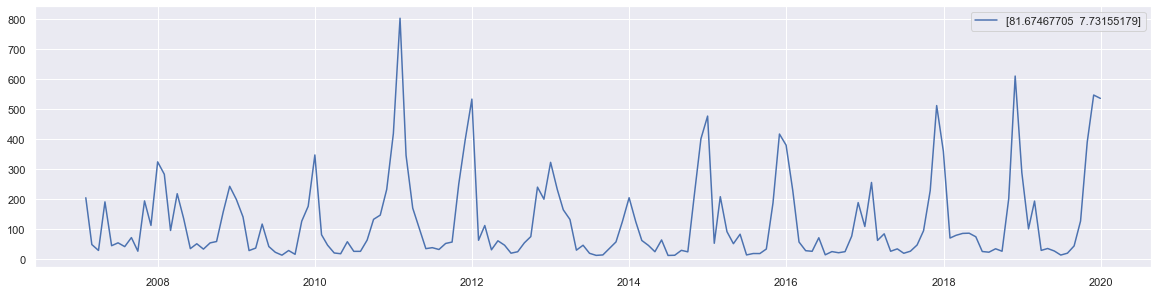

In [36]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
qj=pd.DataFrame(data=datahub, index=DD)
qm=qj.resample('M').sum()
plt.plot(qm)
plt.legend([str(i) for i in stat])
#print qm

## 3) Save daily/monthly precipitations in text files

In [37]:
header=[]
header.extend([str(stat[i]) for i in range(0, len(stat))])
if not os.path.exists('../out'): os.mkdir('../out')
qj.to_csv(r"../out/PJ_SM2RAIN.txt", index=True, header=header, sep=";")
qm.to_csv(r"../out/PM_SM2RAIN.txt", index=True, header=header, sep=";")

## 4) (in progress, non-functional) Generate a text file containing ALL the global pixels, 
The text file will be be opened with Qgis in a raster layer, in order to select the pixels included in a watershed

In [18]:
pd.array([lon_, lat_]).to_csv(os.path.join(path, "grille_mondiale.txt"), index=True, header=['lon', 'lat'], sep=";")

ValueError: PandasArray must be 1-dimensional.